## Import Statements

In [1]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler, LabelBinarizer

## Setup Global Parameters

In [2]:
###----------------
### Some parameters
###----------------

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 1000  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Generate Data Set
<div style="font-family: Arial; font-size:1.2em;">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [3]:
iris = datasets.load_iris()
data_df = pd.DataFrame(data = iris.data,columns=iris.feature_names)
data_df['target'] = iris['target']
X = iris['data']
y = iris['target']

In [4]:
data_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Visualization
<p style="font-family: Arial; font-size:1.2em">
DataFrames are easier to visualize
</p>

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [6]:
data_df.describe() # Generate descriptive statistic

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [7]:
# what labels are present?
data_df.target.unique()

array([0, 1, 2])

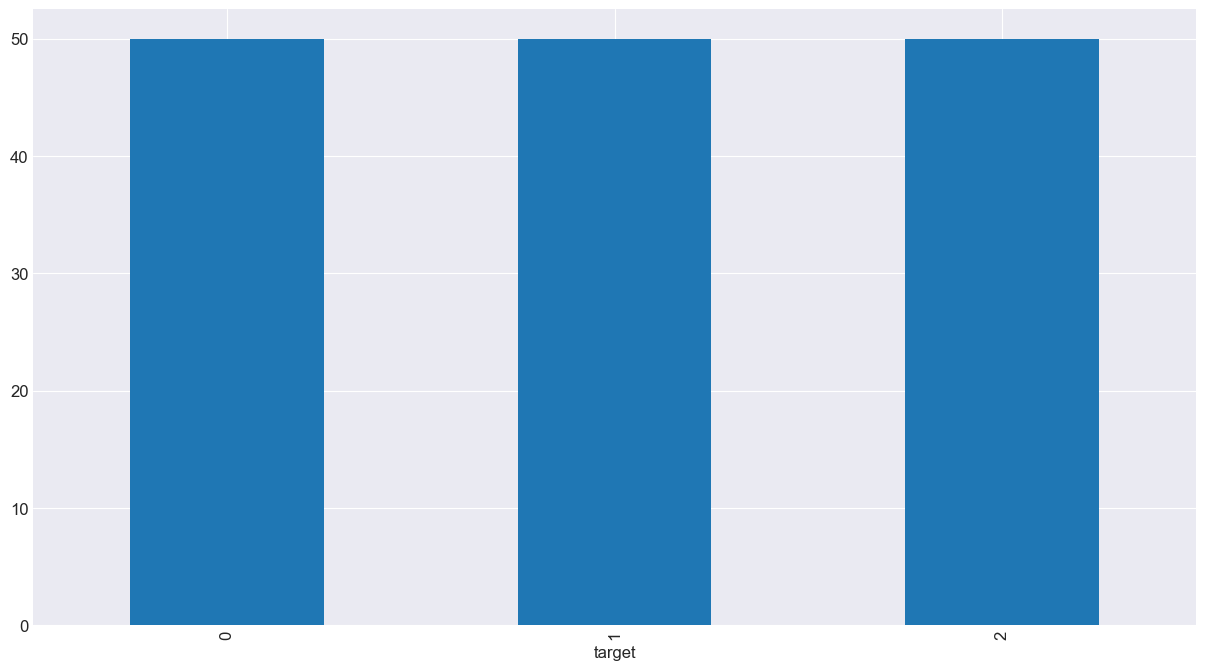

In [8]:
fig, ax = plt.subplots() # Instantiate
    
data_df['target'].value_counts().plot(ax=ax, kind='bar');

In [9]:
X_train,X_test, y_train,y_test =train_test_split(X,y,test_size=TEST_SIZE,stratify=y,random_state = RANDOM_STATE)

In [10]:
X_train.shape,X_test.shape, y_train.shape,y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [13]:
###### without using activation function

In [14]:
### softmaxt function for multiclass
def fn_softmax(z):
    exp_z = np.exp(z)
    return exp_z/(np.sum(exp_z,axis=1,keepdims = True))

def fn_activ(z):
    return np.tanh(z)

def fn_active_prime(z):
    return 1.-np.tanh(z)**2

In [15]:
def predict(model, X_p):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    #### forward propagation

    ## layer 1
    Z1 = X_p.dot(W1)+b1
    a1 = fn_activ(Z1)

    ### Layer 2
    Z2 = a1.dot(W2)+b2
    a2 = fn_softmax(Z2)  ### softmax for multiclass
    
    return np.argmax(a2,axis=1)### pick index of class with highest probability

In [16]:
def Cal_loss(model, X_l,y_l):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    m= X_l.shape[0]
    
    #### forward propagation

    ## layer 1
    Z1 = X_l.dot(W1)+b1
    a1 = fn_activ(Z1)

    ### Layer 2
    Z2 = a1.dot(W2)+b2
    a2 = fn_softmax(Z2)

    data_loss = -(y_l*np.log(a2)+(1-y_l)*np.log(1-a2)).sum()
    
    return data_loss/m

In [17]:
def built_model(X_train,y_train, nn_out, nn_hdim, n_epochs = EPOCHS, alpha = ALPHA):

    '''
    Args:
        X_train: Training features
        y_train: Training labels
        nn_out: size of output
        nn_hdim: number of nodes in hidden layer
    '''  
    m , nn_input_dim  = X_train.shape   
    nn_output_dim = nn_out
    
    ## W1 =  rng.random((nn_input_dim,nn_hdim),dtype = np.float32)/np.sqrt(nn_input_dim)  
    ## W2 =  rng.random((nn_hdim,nn_out),dtype = np.float32)/np.sqrt(nn_hdim)
    ## normally distributed randomly generated data not learning fast enough

    ### size = 2,4
    W1 =  np.random.rand(nn_input_dim,nn_hdim)/np.sqrt(nn_input_dim)

    ### size = 4,2
    W2 =  np.random.rand(nn_hdim,nn_out)/np.sqrt(nn_hdim)

    ### size = 4
    b1 = np.zeros((1,nn_hdim),dtype = 'float32')

    ### size = 2
    b2 = np.zeros((1,nn_out),dtype = 'float32')
    
    curr_loss = 0
    loss, epoch = [],[]
    
    for i in range(0, n_epochs):

        #### forward propagation

        ## layer 1
        Z1 = X_train.dot(W1)+b1
        a1 = fn_activ(Z1)

        ### Layer 2 
        Z2 = a1.dot(W2)+b2
        a2 = fn_softmax(Z2)

        #### Back Propagation

        #### layer 2
        assert (a2.shape == y_train.shape), f'check y{a2.shape}/{y_train.shape}'
        dz2 = a2-y_train  ##### remember dim of a2 and y to be same

        dw2 = (a1.T).dot(dz2)
        assert (W2.shape == dw2.shape), f'check w2 {W2.shape}/{dw2.shape}'

        db2 = np.sum(dz2,axis=0, keepdims = True)
        assert (b2.shape == db2.shape), f'check b2 {b2.shape}/{db2.shape}'

        da1 = dz2.dot(W2.T)
        assert (a1.shape == da1.shape), f'check a1 {a1.shape}/{da1.shape}'

        #### Layer 1 

        dz1 = da1 * fn_active_prime(Z1)
        assert (Z1.shape == dz1.shape), f'check Z1 {z1.shape}/{dz1.shape}' 

        dw1 = (X_train.T).dot(dz1)
        assert (W1.shape == dw1.shape), f'check w1 {W1.shape}/{dw1.shape}'

        db1 = np.sum(dz1,axis=0, keepdims = True)
        assert (b1.shape == db1.shape), f'check b1 {b1.shape}/{db1.shape}'


        ##### gradient update

        W1 += -alpha*dw1/m
        b1 += -alpha*db1/m
        W2 += -alpha*dw2/m
        b2 += -alpha*db2/m

        model = {'W1':W1,'b1':b1,
                'W2':W2,'b2':b2}

        curr_loss = Cal_loss(model,X_train,y_train)
        loss.append(curr_loss)
        epoch.append(i)

        if i%100 == 0 :
            print(f'After epoch: {i:3d} ; loss : {curr_loss:.5f}')
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    return model

In [18]:
nn_out_dim = y_train.shape[1]
nn_hdim = 4

loss_hist = {}

model = built_model(X_train,y_train, nn_out_dim, nn_hdim)

After epoch:   0 ; loss : 1.95957
After epoch: 100 ; loss : 0.74347
After epoch: 200 ; loss : 0.44953
After epoch: 300 ; loss : 0.28880
After epoch: 400 ; loss : 0.21377
After epoch: 500 ; loss : 0.17565
After epoch: 600 ; loss : 0.15339
After epoch: 700 ; loss : 0.13899
After epoch: 800 ; loss : 0.12897
After epoch: 900 ; loss : 0.12165


In [19]:
model

{'W1': array([[ 0.42800189, -0.03057287, -0.12214697,  0.28565765],
        [-0.73081264, -0.12239172, -0.29703186, -0.64149478],
        [ 0.59456421,  0.74121211,  1.47707654,  0.81373544],
        [ 0.86561981,  0.93288983,  1.43317908,  0.70797725]]),
 'b1': array([[ 0.48601836, -0.7713833 , -1.8255888 ,  0.5199901 ]],
       dtype=float32),
 'W2': array([[-1.68801004,  1.25025237,  1.32580545],
        [-0.88612075, -0.10094161,  2.00818223],
        [-0.60957005, -1.379832  ,  3.13032015],
        [-1.31207509,  1.36163415,  1.18955019]]),
 'b2': array([[-0.10432224,  0.47450203, -0.37017888]], dtype=float32)}

<Axes: xlabel='epoch'>

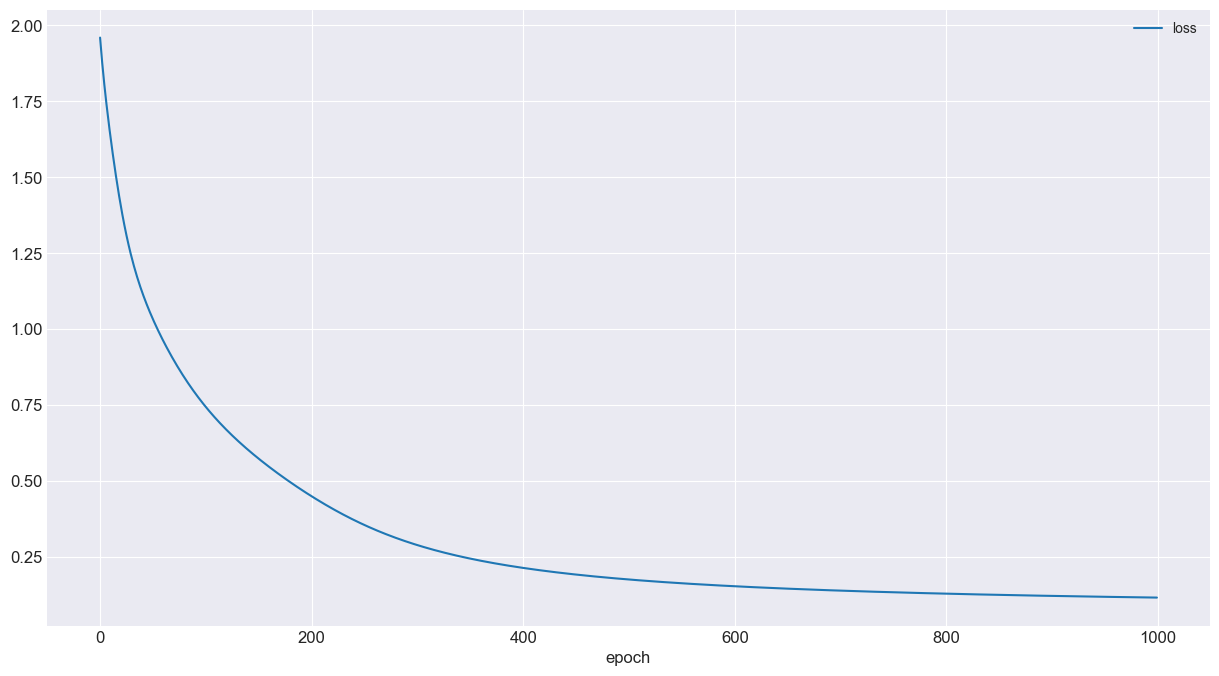

In [20]:
pd.DataFrame(loss_hist).plot(x = 'epoch')

In [21]:
### training accuracy , loss, cf

In [22]:
y_pred = predict(model, X_train)
print(accuracy_score(y_train.argmax(axis=1),y_pred))
print(Cal_loss(model, X_train,y_train))
cm = confusion_matrix(y_train.argmax(axis=1),y_pred)
cm

0.975
0.11613239759806075


array([[40,  0,  0],
       [ 0, 38,  2],
       [ 0,  1, 39]], dtype=int64)

In [23]:
### testing accuracy , loss, cf

In [24]:
y_pred = predict(model, X_test)
print(accuracy_score(y_test.argmax(axis=1),y_pred))
print(Cal_loss(model, X_test,y_test))
cm = confusion_matrix(y_test.argmax(axis=1),y_pred)
cm

0.9666666666666667
0.1074613488310466


array([[10,  0,  0],
       [ 0,  9,  1],
       [ 0,  0, 10]], dtype=int64)

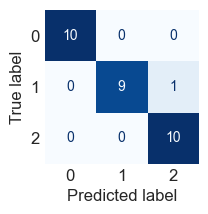

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=[0,1,2])

fig,ax = plt.subplots(figsize=(2,2))
disp.plot(ax = ax,cmap='Blues',colorbar = False)
ax.grid(False)
plt.show()